In [2]:
import torch
import torch.nn as nn


### Ejercicio 1

Escribe código que cree un `torch.tensor` con los siguientes contenidos:
$\begin{bmatrix} 1 & 2.2 & 9.6 \\ 4 & -7.2 & 6.3 \end{bmatrix}$

Ahora calcule el promedio de cada fila (`.mean()`) y cada columna.

¿Cuál es la forma de los resultados?

In [3]:
# Solución
t1 = torch.tensor([1,2.2,9.6,4,-7.2,6.3])
t1 = t1.reshape(2,3)
t1

tensor([[ 1.0000,  2.2000,  9.6000],
        [ 4.0000, -7.2000,  6.3000]])

In [4]:
mean_col = t1.mean(dim=0)
print(f'Vector media por columna {mean_col}')
mean_row = t1.mean(dim=1)
print(f'Vector media por filas {mean_row}')

Vector media por columna tensor([ 2.5000, -2.5000,  7.9500])
Vector media por filas tensor([4.2667, 1.0333])


### Ejercicio 2

Escribe código que cree un `torch.tensor` con los siguientes contenidos:
$\begin{bmatrix} 1 & 2.2 & 9.6 \\ 4 & -7.2 & 6.3 \end{bmatrix}$

¿Cómo se obtiene la primera columna? ¿La primera fila?

In [6]:
t2 = torch.tensor([1,2.2,9.6,4,-7.2,6.3])
t2 = t2.reshape(2,3)
t2

tensor([[ 1.0000,  2.2000,  9.6000],
        [ 4.0000, -7.2000,  6.3000]])

In [7]:
print('primera columna')
print(t2[:,0])
print('primera fila')
print(t2[0,:])

primera columna
tensor([1., 4.])
primera fila
tensor([1.0000, 2.2000, 9.6000])


### Ejercicio 3

Cree una función vectorial (no lineal) en función de dos o tres vectores, determine sus derivadas respecto a cada componente de los vectores, para valores particulares, usando pytorch. Compruebe el resultado.

In [8]:
def partial_derivates(f): 
    """_summary_
    Args:
        f (fuction): _description_: vectorial function
    """
    
    #exec('f = lambda x,y,z: 5*x**2 + y + z')
    f.backward()

    return (x.grad, y.grad, z.grad)

x = torch.tensor(float(5), requires_grad=True)
y = torch.tensor(float(7), requires_grad=True)
z = torch.tensor(float(1), requires_grad=True)
    
partial_derivates(  f = 5*x**2 + y + z)

(tensor(50.), tensor(1.), tensor(1.))

In [9]:
x = torch.tensor(float(5), requires_grad=True)
y = torch.tensor(float(7), requires_grad=True)
z = torch.tensor(float(1), requires_grad=True)

partial_derivates(f = x*y*z)

(tensor(7.), tensor(5.), tensor(35.))

### Ejercicio 4

Use el dataset de `progressive-tweet-sentiment.csv` (el del taller 1), para producir una representación de vectores usando word2vec (máximo 50 vectores). Divida en un conjunto de entrenamiento y otro de prueba. A continuación, realice una clasificación de los tweets con un MLP (multilayer perceptron) de una capa oculta (tendrá que probar cuantas neuronas ocultas), usando como variables la media de los vectores de las palabras de cada tweet. Debe utilizar pytorch. Grafique el loss y el accuracy, tanto para el entrenamiento como para la validación. Escoja el mejor modelo probando con un buen número de epochs (use un learning rate de 0.1 o 0.01).


In [78]:
# librerias
import pandas as pd
import re
#tokenizar con nltk
from nltk.tokenize import word_tokenize
#Word2vec
from gensim.models import Word2Vec

#copy
from copy import deepcopy

#construccion de la red neuronal multicapa (Multilayer perceptron)
#importar librerias
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt


# para iterar combinaciones
from itertools import product



In [2]:
df = pd.read_csv('data/progressive-tweet-sentiment.csv', encoding='latin-1')
df = df[["target", "tweet"]]
df.head()

,target,tweet
0,Legalization of Abortion,Thank you for another day of life Lord. #Chris...
1,Legalization of Abortion,@rosaryrevival Lovely to use Glorious Mysterie...
2,Legalization of Abortion,@Niall250 good thing is that #DUP have consist...
3,Legalization of Abortion,"So, you tell me... is murder okay if the victi..."
4,Legalization of Abortion,@HillaryClinton Don't you mean to say (all chi...


In [3]:
# Limpieza

def limpieza(text):
  text=re.sub(r'@_[A-Za-z0-9]+_','',text) #Remover @_menciones_
  text=re.sub(r'@[A-Za-z0-9]+_[A-Za-z0-9]+','',text) #Remover @menciones_
  text=re.sub(r'@[A-Za-z0-9]+','',text) #Remover @menciones
  text=re.sub(r'https?:\/\/\S+','',text) #Remover Hypervinculos
  text=re.sub(r'RT[\s]+','',text) #Remover Retweets
  text=re.sub(r'[^\w\s]',"",text) #remover signos de puntuacion
  text=re.sub(r'#[A-Za-z0-9]+','',text) #Remover "#"
  text=re.sub(r'[0-9]','',text) #remover numeros
  text=re.sub(r'[^\w\s]',"",text) #remover signos de puntuacion
  text=re.sub(r'\n|\t',' ',text) #remover saltos de linea
  text=re.sub(r'\@',' ',text) #remover "@"
  text=re.sub(r'[\s]+',' ',text) #reemplazar espacios dobles por espacion sencillos
  text=re.sub(r"^[\s]",' ',text) #eliminar espacios al inicio de cada tweet
  text=text.lower() #todo a minuscula
  return text

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop = stopwords.words('english')

#limpieza inicial de los tweetseza)
# Excluir stopwords
df['text_clean']=df["tweet"].apply(limpieza)
df['text_clean'] = df["text_clean"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
df['text_clean'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessuarez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    thank another day life lord christian catholic...
1    lovely use glorious mysteries eastertide mark ...
2    good thing dup consistently said murder wrong ...
3            tell murder okay victim mentally disabled
4    dont mean say children deserve chances except ...
Name: text_clean, dtype: object

In [4]:
# tokenizar
nltk.download("punkt")

#tokenizar cada tweet eliminando stopwords
listado=[]
for i in range(len(df)):
  aux=word_tokenize(df['text_clean'][i])
  aux2=[]
  for word in aux:
    if word not in stop: 
      aux2.append(word)
  listado.append(aux2) 


[nltk_data] Downloading package punkt to /Users/jessuarez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Parametros del modelo word2vec 

vector_size = 50 # numero de elementos del vector que representa la palabra
min_count =3 # Ignores all words with total frequency lower than this. 
workers = 5 # numero de cpu cores
sg = 0 # 0: CBOW, 1: skip-gram
window = 6 # Tamano de la ventana de contexto
sample = 1e-3 # tasa de submuestreo para terminos frecuentes
model = Word2Vec(listado, vector_size=vector_size,min_count=min_count, workers=workers,sg=sg,window=window,sample=sample, seed=123)

In [6]:
#funcion para calcular el promedio de los vectores de cada token por tweet
import numpy as np
tweet_vector=[]
for i in range(len(listado)):
  v1=[0 for i in range(vector_size)]
  for j in range(len(listado[i])):
    if listado[i][j] in model.wv:
      v2=model.wv.get_vector(listado[i][j])
      v2=1/np.log(1+v2)
      v1=[v1[k] + v2[k] for k in range(len(v1))]
  v1=[v1[k]/len(v1) for k in range(len(v1))]
  tweet_vector.append(v1)

#tweet_vector

df2=df[:]
df2
df2['vectors']=tweet_vector
df2.head(n=5)


/var/folders/1z/1h5_y8x165n9_dtqpqg0vsw07w60nb/T/ipykernel_16087/2160571216.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['vectors']=tweet_vector


,target,tweet,text_clean,vectors
0,Legalization of Abortion,Thank you for another day of life Lord. #Chris...,thank another day life lord christian catholic...,"[-10790.094712295533, -5.9132551574707035, -6...."
1,Legalization of Abortion,@rosaryrevival Lovely to use Glorious Mysterie...,lovely use glorious mysteries eastertide mark ...,"[270.1289501953125, 1.2329906463623046, 1.7082..."
2,Legalization of Abortion,@Niall250 good thing is that #DUP have consist...,good thing dup consistently said murder wrong ...,"[-3.9092163848876953, 10.577837219238281, 80.6..."
3,Legalization of Abortion,"So, you tell me... is murder okay if the victi...",tell murder okay victim mentally disabled,"[0.19490753173828124, 17.98672149658203, 2.314..."
4,Legalization of Abortion,@HillaryClinton Don't you mean to say (all chi...,dont mean say children deserve chances except ...,"[58.33499641418457, 14.90863182067871, -22.120..."


In [104]:
# Estandarizando datos Para modelo
df2 = df2.assign(total_sum = df2.vectors.apply( lambda x: sum(x)))

#Eliminamos aquellos sin representación sparsing
df2 = df2.loc[df2.total_sum != 0,:]

# creando vector X 
X=list(df2.vectors)
X= np.asarray(X)

#Estandarizando
sc = StandardScaler()
X = sc.fit_transform(X)

In [105]:
# creando variable target numerica para la red
df2 = df2.assign(target = pd.Categorical(df2.target))
df2 = df2.assign(target_codes = df2.target.cat.codes)

y = list(deepcopy( df2.target_codes))
y= np.asarray(y)

In [106]:
# validando dimensiones
print(X.shape)
print(y.shape)

(1153, 50)
(1153,)


In [107]:
def loss_acc_batch(x,y, model, DEVICE, loss_func, acc = None):
    yp = model(x.to(DEVICE))
    yt = y.to(DEVICE).long() # .long() porque espera un entero tipo long
    loss = loss_func(yp, yt)
    out = [loss, len(x)]
    
    if acc is not None:
        y_pred = torch.argmax(model(x.to(DEVICE)), 1) 
        accuracy = (y_pred == yt).float().mean().item()
        out.append(accuracy)#nar todas las palabras de nuestro vocabulario a un índice correspondiente. Podemos hacerlo de la siguiente
    return out

In [108]:
def train(model, train_dl,DEVICE, loss_func, opt, NUM_EPOCHS, valid_dl):
    
    train_losses = []
    valid_losses = []
    train_accs=[]
    valid_accs=[]
    for epoch in range(NUM_EPOCHS):
        model.train() # importante para activar ciertas funciones como dropout, batchnormalization, etc.
        losses = 0
        nums = 0
        train_acc=[]
        for x, y in train_dl:
            #loss, l = loss_acc_batch(x,y)
            loss, l,acc = loss_acc_batch(x=x,y=y,model=model,loss_func=loss_func,DEVICE=DEVICE,acc=True)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            losses += loss.item() * l
            nums += l
            train_acc.append(acc)
        train_loss = losses / nums
        train_losses.append(train_loss)

        
        model.eval()  #importante para desactivar ciertas funciones como dropout, batchnormalization, etc.
        with torch.no_grad():
            losses, nums, accs = zip(*[loss_acc_batch(x=xb, y=yb,loss_func=loss_func, model = model, DEVICE=DEVICE, acc=True) for xb, yb in valid_dl])
        losses = [l.item() for l in losses]
        valid_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        valid_losses.append(valid_loss)
        
        valid_acc = np.sum(np.multiply(accs,nums)) / np.sum(nums)
        valid_accs.append(valid_acc)
        
        if epoch % 10 == 0:
            print(f"epoch: {epoch}, train_loss: {train_loss:.4f} \
            valid_loss: {valid_loss:.4f}, valid_acc: {valid_acc:.4f}")
    
    
    return train_losses,train_accs,valid_losses,valid_accs 

# Unificando para validar diferentes EPOCAS

In [109]:
def grid_excercise(X, y, RANDOM_SEED=1, BATCH_SIZE=20, NUM_EPOCHS=100, lr=0.01, NUM_HIDDEN = 20, DEVICE = None, get_results =False):
    
    


    ########################################################
    # Ajustando dataset para el modelo
    ########################################################
    torch.manual_seed(RANDOM_SEED); # configurar semilla

    #separar en datos de test y de entrenamiento
    X_train,X_valid,y_train,y_valid = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    #convertir numpy arrays a tensores
    X_train, y_train, X_valid, y_valid = map( lambda x: torch.tensor(x, dtype=torch.float32),
                                            (X_train, y_train, X_valid, y_valid) )

    #convertir a tensor dataset
    train_ds = TensorDataset(X_train, y_train.long())
    valid_ds = TensorDataset(X_valid, y_valid.long())

    #convertir a dataloader
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size = 2*BATCH_SIZE)


    print('tam muestra de entrenamiento')
    print(X_train.shape)
    print(y_train.shape)

    ########################################################
    # Definiendo modelo
    ########################################################
    num_features = X.shape[1]
    num_hidden = NUM_HIDDEN
    num_classes = len(torch.unique(y_train))

    model = nn.Sequential(
        nn.Linear(num_features,num_hidden),
        nn.ReLU(),
        nn.Linear(num_hidden, num_classes)
    )

    loss_func = F.cross_entropy

    model = model.to(DEVICE)

    opt = optim.SGD(model.parameters(),lr = lr)

    train_losses,train_accs,valid_losses,valid_accs=train(model=model,train_dl=train_dl, valid_dl = valid_dl,
                                                            DEVICE=DEVICE, loss_func=loss_func,
                                                            opt = opt, NUM_EPOCHS=NUM_EPOCHS)


    if get_results:
        return train_losses,train_accs,valid_losses,valid_accs
    else:
        return valid_accs[-1]




In [110]:
params_ = {'learning_rate': [0.1, 0.01],
            'NUM_HIDDEN': [10,50,100],
            'epochs': [10,50, 75,100,200]}

In [111]:
%%time
param_names = list(params_.keys())
# zip with parameter names in order to get original property
param_values = (zip(param_names, x) for x in product(*params_.values()))

result_val_acc = list()
output = pd.DataFrame()
for paramset in param_values:
    # use the dict from iterator of tuples constructor
    dict_temp = dict(paramset)
    output = output.append(dict_temp, ignore_index=True)
    # operando la grilla para tener el accuracy y guardar en lista


    result_val_acc.append(grid_excercise(X=X,
                y=y,
                RANDOM_SEED=123,
                BATCH_SIZE=50,
                NUM_EPOCHS=dict_temp['epochs'],
                lr=dict_temp['learning_rate'],
                NUM_HIDDEN = dict_temp['NUM_HIDDEN'],
                DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'), #carga de la red neuronal en la CPU o en la GPU
                get_results= False
                    ))
    

<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.3863             valid_loss: 1.3919, valid_acc: 0.2832


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.3863             valid_loss: 1.3919, valid_acc: 0.2832
epoch: 10, train_loss: 1.1781             valid_loss: 1.3433, valid_acc: 0.3873
epoch: 20, train_loss: 1.0796             valid_loss: 1.3386, valid_acc: 0.3960
epoch: 30, train_loss: 1.0196             valid_loss: 1.3705, valid_acc: 0.4017
epoch: 40, train_loss: 0.9823             valid_loss: 1.3969, valid_acc: 0.3960


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.3863             valid_loss: 1.3919, valid_acc: 0.2832
epoch: 10, train_loss: 1.1781             valid_loss: 1.3433, valid_acc: 0.3873
epoch: 20, train_loss: 1.0796             valid_loss: 1.3386, valid_acc: 0.3960
epoch: 30, train_loss: 1.0196             valid_loss: 1.3705, valid_acc: 0.4017
epoch: 40, train_loss: 0.9823             valid_loss: 1.3969, valid_acc: 0.3960
epoch: 50, train_loss: 0.9308             valid_loss: 1.4041, valid_acc: 0.3931
epoch: 60, train_loss: 0.8926             valid_loss: 1.4790, valid_acc: 0.4075
epoch: 70, train_loss: 0.8741             valid_loss: 1.5217, valid_acc: 0.3902
tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.3863             valid_loss: 1.3919, valid_acc: 0.2832


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch: 10, train_loss: 1.1781             valid_loss: 1.3433, valid_acc: 0.3873
epoch: 20, train_loss: 1.0796             valid_loss: 1.3386, valid_acc: 0.3960
epoch: 30, train_loss: 1.0196             valid_loss: 1.3705, valid_acc: 0.4017
epoch: 40, train_loss: 0.9823             valid_loss: 1.3969, valid_acc: 0.3960
epoch: 50, train_loss: 0.9308             valid_loss: 1.4041, valid_acc: 0.3931
epoch: 60, train_loss: 0.8926             valid_loss: 1.4790, valid_acc: 0.4075
epoch: 70, train_loss: 0.8741             valid_loss: 1.5217, valid_acc: 0.3902
epoch: 80, train_loss: 0.8407             valid_loss: 1.5964, valid_acc: 0.4046
epoch: 90, train_loss: 0.8406             valid_loss: 1.6542, valid_acc: 0.4104
tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.3863             valid_loss: 1.3919, valid_acc: 0.2832


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch: 10, train_loss: 1.1781             valid_loss: 1.3433, valid_acc: 0.3873
epoch: 20, train_loss: 1.0796             valid_loss: 1.3386, valid_acc: 0.3960
epoch: 30, train_loss: 1.0196             valid_loss: 1.3705, valid_acc: 0.4017
epoch: 40, train_loss: 0.9823             valid_loss: 1.3969, valid_acc: 0.3960
epoch: 50, train_loss: 0.9308             valid_loss: 1.4041, valid_acc: 0.3931
epoch: 60, train_loss: 0.8926             valid_loss: 1.4790, valid_acc: 0.4075
epoch: 70, train_loss: 0.8741             valid_loss: 1.5217, valid_acc: 0.3902
epoch: 80, train_loss: 0.8407             valid_loss: 1.5964, valid_acc: 0.4046
epoch: 90, train_loss: 0.8406             valid_loss: 1.6542, valid_acc: 0.4104
epoch: 100, train_loss: 0.8018             valid_loss: 1.7338, valid_acc: 0.3902
epoch: 110, train_loss: 0.7916             valid_loss: 1.7828, valid_acc: 0.4104
epoch: 120, train_loss: 0.7736             valid_loss: 1.8493, valid_acc: 0.4191
epoch: 130, train_loss: 0.7656       

<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.3862             valid_loss: 1.3622, valid_acc: 0.3179


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.3862             valid_loss: 1.3622, valid_acc: 0.3179
epoch: 10, train_loss: 1.1130             valid_loss: 1.3234, valid_acc: 0.3699
epoch: 20, train_loss: 0.9698             valid_loss: 1.3738, valid_acc: 0.4075
epoch: 30, train_loss: 0.8663             valid_loss: 1.4125, valid_acc: 0.4249
epoch: 40, train_loss: 0.7723             valid_loss: 1.5189, valid_acc: 0.4162


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.3862             valid_loss: 1.3622, valid_acc: 0.3179
epoch: 10, train_loss: 1.1130             valid_loss: 1.3234, valid_acc: 0.3699
epoch: 20, train_loss: 0.9698             valid_loss: 1.3738, valid_acc: 0.4075
epoch: 30, train_loss: 0.8663             valid_loss: 1.4125, valid_acc: 0.4249
epoch: 40, train_loss: 0.7723             valid_loss: 1.5189, valid_acc: 0.4162
epoch: 50, train_loss: 0.7034             valid_loss: 1.5674, valid_acc: 0.4162
epoch: 60, train_loss: 0.6321             valid_loss: 1.6721, valid_acc: 0.4104
epoch: 70, train_loss: 0.5759             valid_loss: 1.7243, valid_acc: 0.4422
tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch: 0, train_loss: 1.3862             valid_loss: 1.3622, valid_acc: 0.3179
epoch: 10, train_loss: 1.1130             valid_loss: 1.3234, valid_acc: 0.3699
epoch: 20, train_loss: 0.9698             valid_loss: 1.3738, valid_acc: 0.4075
epoch: 30, train_loss: 0.8663             valid_loss: 1.4125, valid_acc: 0.4249
epoch: 40, train_loss: 0.7723             valid_loss: 1.5189, valid_acc: 0.4162
epoch: 50, train_loss: 0.7034             valid_loss: 1.5674, valid_acc: 0.4162
epoch: 60, train_loss: 0.6321             valid_loss: 1.6721, valid_acc: 0.4104
epoch: 70, train_loss: 0.5759             valid_loss: 1.7243, valid_acc: 0.4422
epoch: 80, train_loss: 0.5244             valid_loss: 1.8678, valid_acc: 0.4422
epoch: 90, train_loss: 0.4782             valid_loss: 1.8962, valid_acc: 0.4480


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.3862             valid_loss: 1.3622, valid_acc: 0.3179
epoch: 10, train_loss: 1.1130             valid_loss: 1.3234, valid_acc: 0.3699
epoch: 20, train_loss: 0.9698             valid_loss: 1.3738, valid_acc: 0.4075
epoch: 30, train_loss: 0.8663             valid_loss: 1.4125, valid_acc: 0.4249
epoch: 40, train_loss: 0.7723             valid_loss: 1.5189, valid_acc: 0.4162
epoch: 50, train_loss: 0.7034             valid_loss: 1.5674, valid_acc: 0.4162
epoch: 60, train_loss: 0.6321             valid_loss: 1.6721, valid_acc: 0.4104
epoch: 70, train_loss: 0.5759             valid_loss: 1.7243, valid_acc: 0.4422
epoch: 80, train_loss: 0.5244             valid_loss: 1.8678, valid_acc: 0.4422
epoch: 90, train_loss: 0.4782             valid_loss: 1.8962, valid_acc: 0.4480
epoch: 100, train_loss: 0.4355             valid_loss: 2.0092, valid_acc: 0.4422
epoch: 110, train_loss: 0.4427             valid_lo

<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4001             valid_loss: 1.3572, valid_acc: 0.2919


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4001             valid_loss: 1.3572, valid_acc: 0.2919
epoch: 10, train_loss: 1.0929             valid_loss: 1.3090, valid_acc: 0.3931
epoch: 20, train_loss: 0.9415             valid_loss: 1.3633, valid_acc: 0.4017
epoch: 30, train_loss: 0.8268             valid_loss: 1.4271, valid_acc: 0.4393
epoch: 40, train_loss: 0.7268             valid_loss: 1.5314, valid_acc: 0.4364


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4001             valid_loss: 1.3572, valid_acc: 0.2919
epoch: 10, train_loss: 1.0929             valid_loss: 1.3090, valid_acc: 0.3931
epoch: 20, train_loss: 0.9415             valid_loss: 1.3633, valid_acc: 0.4017
epoch: 30, train_loss: 0.8268             valid_loss: 1.4271, valid_acc: 0.4393
epoch: 40, train_loss: 0.7268             valid_loss: 1.5314, valid_acc: 0.4364
epoch: 50, train_loss: 0.6419             valid_loss: 1.6128, valid_acc: 0.4393
epoch: 60, train_loss: 0.5732             valid_loss: 1.6896, valid_acc: 0.4335
epoch: 70, train_loss: 0.5156             valid_loss: 1.7746, valid_acc: 0.4220
tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4001             valid_loss: 1.3572, valid_acc: 0.2919


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch: 10, train_loss: 1.0929             valid_loss: 1.3090, valid_acc: 0.3931
epoch: 20, train_loss: 0.9415             valid_loss: 1.3633, valid_acc: 0.4017
epoch: 30, train_loss: 0.8268             valid_loss: 1.4271, valid_acc: 0.4393
epoch: 40, train_loss: 0.7268             valid_loss: 1.5314, valid_acc: 0.4364
epoch: 50, train_loss: 0.6419             valid_loss: 1.6128, valid_acc: 0.4393
epoch: 60, train_loss: 0.5732             valid_loss: 1.6896, valid_acc: 0.4335
epoch: 70, train_loss: 0.5156             valid_loss: 1.7746, valid_acc: 0.4220
epoch: 80, train_loss: 0.4588             valid_loss: 1.8672, valid_acc: 0.4277
epoch: 90, train_loss: 0.4019             valid_loss: 1.9688, valid_acc: 0.4624


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4001             valid_loss: 1.3572, valid_acc: 0.2919
epoch: 10, train_loss: 1.0929             valid_loss: 1.3090, valid_acc: 0.3931
epoch: 20, train_loss: 0.9415             valid_loss: 1.3633, valid_acc: 0.4017
epoch: 30, train_loss: 0.8268             valid_loss: 1.4271, valid_acc: 0.4393
epoch: 40, train_loss: 0.7268             valid_loss: 1.5314, valid_acc: 0.4364
epoch: 50, train_loss: 0.6419             valid_loss: 1.6128, valid_acc: 0.4393
epoch: 60, train_loss: 0.5732             valid_loss: 1.6896, valid_acc: 0.4335
epoch: 70, train_loss: 0.5156             valid_loss: 1.7746, valid_acc: 0.4220
epoch: 80, train_loss: 0.4588             valid_loss: 1.8672, valid_acc: 0.4277
epoch: 90, train_loss: 0.4019             valid_loss: 1.9688, valid_acc: 0.4624
epoch: 100, train_loss: 0.3622             valid_loss: 2.0900, valid_acc: 0.4364
epoch: 110, train_loss: 0.3439             valid_lo

<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4002             valid_loss: 1.4090, valid_acc: 0.2514


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4002             valid_loss: 1.4090, valid_acc: 0.2514
epoch: 10, train_loss: 1.3567             valid_loss: 1.3895, valid_acc: 0.2861
epoch: 20, train_loss: 1.3263             valid_loss: 1.3789, valid_acc: 0.3208
epoch: 30, train_loss: 1.2997             valid_loss: 1.3711, valid_acc: 0.3179
epoch: 40, train_loss: 1.2751             valid_loss: 1.3660, valid_acc: 0.3266


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4002             valid_loss: 1.4090, valid_acc: 0.2514
epoch: 10, train_loss: 1.3567             valid_loss: 1.3895, valid_acc: 0.2861
epoch: 20, train_loss: 1.3263             valid_loss: 1.3789, valid_acc: 0.3208
epoch: 30, train_loss: 1.2997             valid_loss: 1.3711, valid_acc: 0.3179
epoch: 40, train_loss: 1.2751             valid_loss: 1.3660, valid_acc: 0.3266
epoch: 50, train_loss: 1.2524             valid_loss: 1.3601, valid_acc: 0.3526
epoch: 60, train_loss: 1.2316             valid_loss: 1.3568, valid_acc: 0.3526
epoch: 70, train_loss: 1.2128             valid_loss: 1.3527, valid_acc: 0.3642
tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


epoch: 0, train_loss: 1.4002             valid_loss: 1.4090, valid_acc: 0.2514
epoch: 10, train_loss: 1.3567             valid_loss: 1.3895, valid_acc: 0.2861
epoch: 20, train_loss: 1.3263             valid_loss: 1.3789, valid_acc: 0.3208
epoch: 30, train_loss: 1.2997             valid_loss: 1.3711, valid_acc: 0.3179
epoch: 40, train_loss: 1.2751             valid_loss: 1.3660, valid_acc: 0.3266
epoch: 50, train_loss: 1.2524             valid_loss: 1.3601, valid_acc: 0.3526
epoch: 60, train_loss: 1.2316             valid_loss: 1.3568, valid_acc: 0.3526
epoch: 70, train_loss: 1.2128             valid_loss: 1.3527, valid_acc: 0.3642
epoch: 80, train_loss: 1.1962             valid_loss: 1.3492, valid_acc: 0.3642
epoch: 90, train_loss: 1.1811             valid_loss: 1.3479, valid_acc: 0.3757


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4002             valid_loss: 1.4090, valid_acc: 0.2514
epoch: 10, train_loss: 1.3567             valid_loss: 1.3895, valid_acc: 0.2861
epoch: 20, train_loss: 1.3263             valid_loss: 1.3789, valid_acc: 0.3208
epoch: 30, train_loss: 1.2997             valid_loss: 1.3711, valid_acc: 0.3179
epoch: 40, train_loss: 1.2751             valid_loss: 1.3660, valid_acc: 0.3266
epoch: 50, train_loss: 1.2524             valid_loss: 1.3601, valid_acc: 0.3526
epoch: 60, train_loss: 1.2316             valid_loss: 1.3568, valid_acc: 0.3526
epoch: 70, train_loss: 1.2128             valid_loss: 1.3527, valid_acc: 0.3642
epoch: 80, train_loss: 1.1962             valid_loss: 1.3492, valid_acc: 0.3642
epoch: 90, train_loss: 1.1811             valid_loss: 1.3479, valid_acc: 0.3757
epoch: 100, train_loss: 1.1665             valid_loss: 1.3458, valid_acc: 0.3815
epoch: 110, train_loss: 1.1531             valid_lo

<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4136             valid_loss: 1.3953, valid_acc: 0.3439


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4136             valid_loss: 1.3953, valid_acc: 0.3439
epoch: 10, train_loss: 1.3406             valid_loss: 1.3648, valid_acc: 0.3266
epoch: 20, train_loss: 1.3059             valid_loss: 1.3560, valid_acc: 0.3353
epoch: 30, train_loss: 1.2754             valid_loss: 1.3466, valid_acc: 0.3699
epoch: 40, train_loss: 1.2457             valid_loss: 1.3392, valid_acc: 0.3757


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4136             valid_loss: 1.3953, valid_acc: 0.3439
epoch: 10, train_loss: 1.3406             valid_loss: 1.3648, valid_acc: 0.3266
epoch: 20, train_loss: 1.3059             valid_loss: 1.3560, valid_acc: 0.3353
epoch: 30, train_loss: 1.2754             valid_loss: 1.3466, valid_acc: 0.3699
epoch: 40, train_loss: 1.2457             valid_loss: 1.3392, valid_acc: 0.3757
epoch: 50, train_loss: 1.2173             valid_loss: 1.3332, valid_acc: 0.3728
epoch: 60, train_loss: 1.1901             valid_loss: 1.3278, valid_acc: 0.3613
epoch: 70, train_loss: 1.1644             valid_loss: 1.3250, valid_acc: 0.3728


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4136             valid_loss: 1.3953, valid_acc: 0.3439
epoch: 10, train_loss: 1.3406             valid_loss: 1.3648, valid_acc: 0.3266
epoch: 20, train_loss: 1.3059             valid_loss: 1.3560, valid_acc: 0.3353
epoch: 30, train_loss: 1.2754             valid_loss: 1.3466, valid_acc: 0.3699
epoch: 40, train_loss: 1.2457             valid_loss: 1.3392, valid_acc: 0.3757
epoch: 50, train_loss: 1.2173             valid_loss: 1.3332, valid_acc: 0.3728
epoch: 60, train_loss: 1.1901             valid_loss: 1.3278, valid_acc: 0.3613
epoch: 70, train_loss: 1.1644             valid_loss: 1.3250, valid_acc: 0.3728
epoch: 80, train_loss: 1.1399             valid_loss: 1.3246, valid_acc: 0.3757
epoch: 90, train_loss: 1.1175             valid_loss: 1.3238, valid_acc: 0.3728


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4136             valid_loss: 1.3953, valid_acc: 0.3439
epoch: 10, train_loss: 1.3406             valid_loss: 1.3648, valid_acc: 0.3266
epoch: 20, train_loss: 1.3059             valid_loss: 1.3560, valid_acc: 0.3353
epoch: 30, train_loss: 1.2754             valid_loss: 1.3466, valid_acc: 0.3699
epoch: 40, train_loss: 1.2457             valid_loss: 1.3392, valid_acc: 0.3757
epoch: 50, train_loss: 1.2173             valid_loss: 1.3332, valid_acc: 0.3728
epoch: 60, train_loss: 1.1901             valid_loss: 1.3278, valid_acc: 0.3613
epoch: 70, train_loss: 1.1644             valid_loss: 1.3250, valid_acc: 0.3728
epoch: 80, train_loss: 1.1399             valid_loss: 1.3246, valid_acc: 0.3757
epoch: 90, train_loss: 1.1175             valid_loss: 1.3238, valid_acc: 0.3728
epoch: 100, train_loss: 1.0968             valid_loss: 1.3250, valid_acc: 0.3786
epoch: 110, train_loss: 1.0770             valid_lo

<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4372             valid_loss: 1.3996, valid_acc: 0.2486


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4372             valid_loss: 1.3996, valid_acc: 0.2486
epoch: 10, train_loss: 1.3427             valid_loss: 1.3546, valid_acc: 0.2890
epoch: 20, train_loss: 1.2975             valid_loss: 1.3392, valid_acc: 0.3382
epoch: 30, train_loss: 1.2623             valid_loss: 1.3298, valid_acc: 0.3526
epoch: 40, train_loss: 1.2299             valid_loss: 1.3219, valid_acc: 0.3671


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4372             valid_loss: 1.3996, valid_acc: 0.2486
epoch: 10, train_loss: 1.3427             valid_loss: 1.3546, valid_acc: 0.2890
epoch: 20, train_loss: 1.2975             valid_loss: 1.3392, valid_acc: 0.3382
epoch: 30, train_loss: 1.2623             valid_loss: 1.3298, valid_acc: 0.3526
epoch: 40, train_loss: 1.2299             valid_loss: 1.3219, valid_acc: 0.3671
epoch: 50, train_loss: 1.2007             valid_loss: 1.3143, valid_acc: 0.3699
epoch: 60, train_loss: 1.1734             valid_loss: 1.3091, valid_acc: 0.3844
epoch: 70, train_loss: 1.1474             valid_loss: 1.3061, valid_acc: 0.3786


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4372             valid_loss: 1.3996, valid_acc: 0.2486
epoch: 10, train_loss: 1.3427             valid_loss: 1.3546, valid_acc: 0.2890
epoch: 20, train_loss: 1.2975             valid_loss: 1.3392, valid_acc: 0.3382
epoch: 30, train_loss: 1.2623             valid_loss: 1.3298, valid_acc: 0.3526
epoch: 40, train_loss: 1.2299             valid_loss: 1.3219, valid_acc: 0.3671
epoch: 50, train_loss: 1.2007             valid_loss: 1.3143, valid_acc: 0.3699
epoch: 60, train_loss: 1.1734             valid_loss: 1.3091, valid_acc: 0.3844
epoch: 70, train_loss: 1.1474             valid_loss: 1.3061, valid_acc: 0.3786
epoch: 80, train_loss: 1.1234             valid_loss: 1.3025, valid_acc: 0.3960
epoch: 90, train_loss: 1.1002             valid_loss: 1.3029, valid_acc: 0.3931


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.4372             valid_loss: 1.3996, valid_acc: 0.2486
epoch: 10, train_loss: 1.3427             valid_loss: 1.3546, valid_acc: 0.2890
epoch: 20, train_loss: 1.2975             valid_loss: 1.3392, valid_acc: 0.3382
epoch: 30, train_loss: 1.2623             valid_loss: 1.3298, valid_acc: 0.3526
epoch: 40, train_loss: 1.2299             valid_loss: 1.3219, valid_acc: 0.3671
epoch: 50, train_loss: 1.2007             valid_loss: 1.3143, valid_acc: 0.3699
epoch: 60, train_loss: 1.1734             valid_loss: 1.3091, valid_acc: 0.3844
epoch: 70, train_loss: 1.1474             valid_loss: 1.3061, valid_acc: 0.3786
epoch: 80, train_loss: 1.1234             valid_loss: 1.3025, valid_acc: 0.3960
epoch: 90, train_loss: 1.1002             valid_loss: 1.3029, valid_acc: 0.3931
epoch: 100, train_loss: 1.0789             valid_loss: 1.3038, valid_acc: 0.4046
epoch: 110, train_loss: 1.0583             valid_lo

In [116]:
output = output.assign(acc_val = result_val_acc)
print('MEJOR COMBINACIÓN DE Parametros')
best_params = output.loc[output.acc_val == output.acc_val.max()].reset_index()
best_params

MEJOR COMBINACIÓN DE Parametros


,index,learning_rate,NUM_HIDDEN,epochs,acc_val
0,8,0.1,50.0,100.0,0.445087


In [138]:
LR= best_params.learning_rate[0]
NUM_EPOCHS = int(best_params.epochs[0])
NUM_HIDDEN = int(best_params.NUM_HIDDEN[0])

In [139]:
train_losses,train_accs,valid_losses,valid_accs = grid_excercise(X=X,
                                                                 y=y,
                                                                 RANDOM_SEED=123,
                                                                 BATCH_SIZE=50,
                                                                 NUM_EPOCHS=NUM_EPOCHS,
                                                                 lr=LR,
                                                                 NUM_HIDDEN = NUM_HIDDEN,
                                                                 DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'), #carga de la red neuronal en la CPU o en la GPU
                                                                 get_results= True)

tam muestra de entrenamiento
torch.Size([807, 50])
torch.Size([807])
epoch: 0, train_loss: 1.3862             valid_loss: 1.3622, valid_acc: 0.3179
epoch: 10, train_loss: 1.1130             valid_loss: 1.3234, valid_acc: 0.3699
epoch: 20, train_loss: 0.9698             valid_loss: 1.3738, valid_acc: 0.4075
epoch: 30, train_loss: 0.8663             valid_loss: 1.4125, valid_acc: 0.4249
epoch: 40, train_loss: 0.7723             valid_loss: 1.5189, valid_acc: 0.4162
epoch: 50, train_loss: 0.7034             valid_loss: 1.5674, valid_acc: 0.4162
epoch: 60, train_loss: 0.6321             valid_loss: 1.6721, valid_acc: 0.4104
epoch: 70, train_loss: 0.5759             valid_loss: 1.7243, valid_acc: 0.4422
epoch: 80, train_loss: 0.5244             valid_loss: 1.8678, valid_acc: 0.4422
epoch: 90, train_loss: 0.4782             valid_loss: 1.8962, valid_acc: 0.4480


Text(0.5, 1.0, 'Loss')

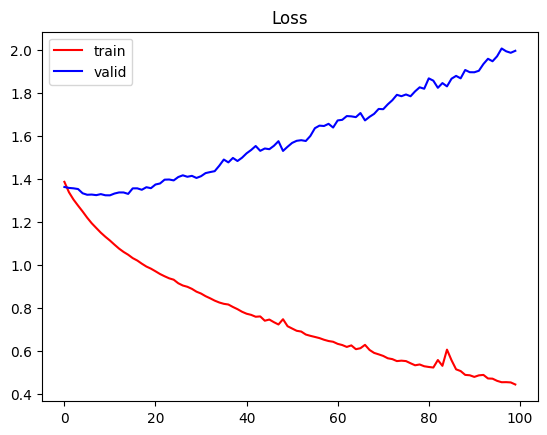

In [140]:
NUM_EPOCHS=100

plt.plot(range(NUM_EPOCHS), train_losses, 'r', label='train')
plt.plot(range(NUM_EPOCHS), valid_losses, 'b', label = 'valid')
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

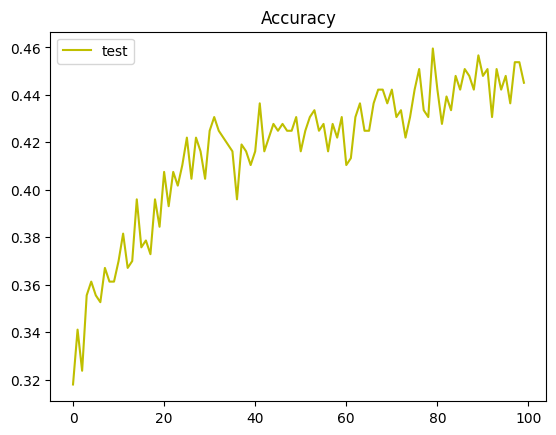

In [141]:
plt.plot(range(NUM_EPOCHS), valid_accs, 'y', label = 'test')
plt.legend()
plt.title('Accuracy')

-----

### Ejercicio 5
Este ejercicio, es más bien un tutorial de como realizar un clasificador de ventanas de palabras, acercandónos a un problema de NLP conocido como "Name Entity Recognition" (NER), el cual busca clasificar cada palabra en por ejemplo si es un nombre, pronombre, verbo, lugar, etc. Esto es muy importante, porque introduce varias cuestiones claves que se usan en el NLP con deep learning. Al final, el ejercicio será (1) entender cada parte y (2) realizar el mismo procedimiento pero clasificando entre varios tipos de palabras (no sólo una). 

### Clasificación de ventanas de palabras (Word Window Classification) paso a paso

En esta tarea de NLP aprenderemos:

1. Datos: creación de un conjunto de datos de tensores por batches
2. Modelado
3. Entrenamiento
4. Predicción

En esta sección, nuestro objetivo será entrenar un modelo que encuentre las palabras en una oración correspondiente a una 'UBICACIÓN', que siempre tendrá un intervalo de '1' (lo que significa que 'San Francisco' no se reconocerá como un `UBICACIÓN`). Nuestra tarea se llama `Clasificación de ventana de palabras` por una razón. En lugar de permitir que nuestro modelo solo eche un vistazo a una palabra en cada paso hacia adelante, nos gustaría que pudiera considerar el contexto de la palabra en cuestión. Es decir, para cada palabra, queremos que nuestro modelo sea consciente de las palabras que lo rodean.

In [142]:
# Nuestros datos sin procesar, que consisten en oraciones
corpus = [
          "Nosotros siempre venimos a París",
          "El profesor es de Australia",
          "Yo vivo en Bogotá",
          "Él viene de Taiwán",
          "La capital de Turquía es Ankara"
         ]

#### Preprocesamiento

Para facilitar el aprendizaje de nuestros modelos, generalmente aplicamos algunos pasos de preprocesamiento a nuestros datos. Esto es especialmente importante cuando se trata de datos de texto. Estos son algunos ejemplos de preprocesamiento de texto:
* **Tokenización**: Tokenización de oraciones en palabras.
* **Lowercasing**: Cambiar todas las letras a minúsculas.
* **Eliminación de ruido**: Eliminación de caracteres especiales (como signos de puntuación o quitar tíldes).
* **Eliminación de palabras vacías**: eliminación de palabras de uso común.

Los pasos de preprocesamiento necesarios están determinados por la tarea en cuestión. Por ejemplo, aunque es útil eliminar caracteres especiales en algunas tareas, para otras pueden ser importantes (por ejemplo, si estamos hablando de varios idiomas). Para nuestra tarea, escribiremos en minúsculas nuestras palabras y tokenizaremos.

In [143]:
import re
from unicodedata import normalize
def quitartildes(s):
    # -> NFD y eliminar diacríticos
    s = re.sub(
            r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
            normalize( "NFD", s), 0, re.I
        )

    # -> NFCNosotros
    return normalize( 'NFC', s)

In [144]:
# La función de preprocesamiento que usaremos para generar nuestros ejemplos de entrenamiento
# Nuestra función es simple, ponemos las letras en minúsculas, quitamos tildes
# y luego tokenizamos las palabras.
def preprocess_sentence(sentence):
  return quitartildes(sentence).lower().split()

# Crea nuestro conjunto de entrenamiento
train_sentences = [preprocess_sentence(sent) for sent in corpus]
train_sentences

[['nosotros', 'siempre', 'venimos', 'a', 'paris'],
 ['el', 'profesor', 'es', 'de', 'australia'],
 ['yo', 'vivo', 'en', 'bogota'],
 ['el', 'viene', 'de', 'taiwan'],
 ['la', 'capital', 'de', 'turquia', 'es', 'ankara']]

Para cada ejemplo de entrenamiento que tengamos, también deberíamos tener una etiqueta correspondiente. Recuerde que el objetivo de nuestro modelo era determinar qué palabras corresponden a una `UBICACIÓN`. Es decir, queremos que nuestro modelo genere `0` para todas las palabras que no sean `UBICACION` y `1` para las que sean `UBICACION`.

In [145]:
# Set de ubicaciones que aparecen en el corpus
locations = set(["australia", "ankara", "paris", "bogota", "taiwan", "turquia"])

# Nuestras etiquetas de entrenamiento
train_labels = [[1 if word in locations else 0 for word in sent] for sent in train_sentences]
train_labels

[[0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 0, 1, 0, 1]]

#### Convertir palabras a Embeddings

Veamos nuestros datos de entrenamiento un poco más de cerca. Cada punto de datos que tenemos es una secuencia de palabras. Por otro lado, sabemos que los modelos de aprendizaje automático funcionan con números en vectores. ¿Cómo vamos a convertir las palabras en números? ¡A través de los embeddings!

Imagine que tenemos una tabla de búsqueda de embeddings `E`, donde cada fila corresponde a un embedding. Es decir, cada palabra de nuestro vocabulario tendría una fila de embedding `i` correspondiente en esta tabla. Siempre que queramos encontrar una embedding para una palabra, seguiremos estos pasos:
1. Buscar el índice correspondiente `i` de la palabra en la tabla de embedding: `palabra->índice`.
2. Indexar en la tabla de embedding y obtener el embedding: `índice->embedding`.

Veamos el primer paso. Deberíamos asignar todas las palabras de nuestro vocabulario a un índice correspondiente. Podemos hacerlo de la siguiente manera:
1. Encontrando todas las palabras únicas en nuestro corpus.
2. Asignando un índice a cada uno.

In [146]:
# Encuentra todas las palabras únicas en nuestro corpus
vocabulary = set(w for s in train_sentences for w in s)
vocabulary

{'a',
 'ankara',
 'australia',
 'bogota',
 'capital',
 'de',
 'el',
 'en',
 'es',
 'la',
 'nosotros',
 'paris',
 'profesor',
 'siempre',
 'taiwan',
 'turquia',
 'venimos',
 'viene',
 'vivo',
 'yo'}

`vocabulary` ahora contiene todas las palabras en nuestro corpus. Por otro lado, durante la (evaluación con el conjunto de) prueba, podemos ver palabras que no están contenidas en nuestro vocabulario. Si podemos encontrar una forma de representar las palabras desconocidas, nuestro modelo aún podría razonar sobre si son una 'UBICACIÓN' o no, ya que también estamos mirando las palabras vecinas para cada predicción.

Introducimos un token especial, `<unk>`, para abordar las palabras que están fuera del vocabulario. Podríamos elegir otra cadena para nuestro token desconocido si quisiéramos. El único requisito aquí es que nuestro token debe ser único: solo debemos usar este token para palabras desconocidas. También agregaremos este token especial a nuestro vocabulario.

In [147]:
# Agrega el token desconocido a nuestro vocabulario
vocabulary.add("<unk>")

Anteriormente mencionamos que nuestra tarea se llamaba "Clasificación de ventana de palabras" porque nuestro modelo está mirando las palabras circundantes además de la palabra central, cuando se necesita hacer una predicción.

Por ejemplo, tomemos la oración "Nosotros siempre venimos a París". La etiqueta de entrenamiento correspondiente para esta oración es `0, 0, 0, 0, 1` ya que solo París, la última palabra, es una `UBICACIÓN`. En una sola pasada (es decir, una llamada a `forward()`), nuestro modelo intentará generar la etiqueta correcta para una palabra. Digamos que nuestro modelo intenta generar la etiqueta correcta `1` para `París`. Si solo permitimos que nuestro modelo vea `París`, pero nada más, nos perderemos información importante, como por ejemplo, de que la palabra 'a' aparece muchas veces con `UBICACIONES`.

Las ventanas de palabras permiten que nuestro modelo considere `+N` o `-N` palabras alrededor de cada palabra al hacer una predicción. En nuestro ejemplo anterior para `París`, si tenemos un tamaño de ventana de 1, eso significa que nuestro modelo mirará las palabras que vienen inmediatamente antes e inmediatamente después de `París`, que son `a` y, *ninguna palabra*. Ahora bien, esto plantea otro problema. `París` está al final de nuestra oración, por lo que no hay otra palabra que la siga. Recuerde que definimos las dimensiones de entrada de nuestros modelos en `PyTorch` cuando los inicializamos. Si establecemos el tamaño de la ventana en `1`, significa que nuestro modelo aceptará `3` palabras en cada paso. No podemos hacer que nuestro modelo espere `2` palabras de vez en cuando.

La solución es introducir un token especial, `<pad>`, que se agregará a nuestras oraciones para asegurarnos de que cada palabra tenga una ventana válida alrededor. Similar al token `<unk>`, podríamos elegir otra cadena para nuestro token de relleno si quisiéramos, siempre y cuando nos aseguremos de que se use para un propósito único.

In [148]:
# Agregua el token <pad> a nuestro vocabulario
vocabulary.add("<pad>")

# Función que rellena la oración dada
# Estamos introduciendo esta función aquí como un ejemplo
# Lo utilizaremos más adelante en el tutorial.
def pad_window(sentence, window_size, pad_token="<pad>"):
  window = [pad_token] * window_size
  return window + sentence + window

# Muestra un ejemplo de relleno
window_size = 2
pad_window(train_sentences[0], window_size=window_size)

['<pad>',
 '<pad>',
 'nosotros',
 'siempre',
 'venimos',
 'a',
 'paris',
 '<pad>',
 '<pad>']

Ahora que nuestro vocabulario está listo, asignemos un índice a cada una de nuestras palabras.

In [149]:
# Solo estamos convirtiendo nuestro vocabulario en una lista para poder indexarla
# Aunque ordenar no es necesario, ordenamos para mostrar un diccionario word_to_ind ordenado
# Dicho esto, veremos que tener el índice para el token de relleno
# como 0 es conveniente ya que algunas funciones de PyTorch lo usan como valor predeterminado
# como sucede con nn.utils.rnn.pad_sequence, que veremos en un momento
ix_to_word = sorted(list(vocabulary))

# Creando un diccionario para encontrar el índice de una palabra dada
word_to_ix = {word: ind for ind, word in enumerate(ix_to_word)}
word_to_ix

{'<pad>': 0,
 '<unk>': 1,
 'a': 2,
 'ankara': 3,
 'australia': 4,
 'bogota': 5,
 'capital': 6,
 'de': 7,
 'el': 8,
 'en': 9,
 'es': 10,
 'la': 11,
 'nosotros': 12,
 'paris': 13,
 'profesor': 14,
 'siempre': 15,
 'taiwan': 16,
 'turquia': 17,
 'venimos': 18,
 'viene': 19,
 'vivo': 20,
 'yo': 21}

In [150]:
ix_to_word[1]

'<unk>'

Ahora, estamos listos para convertir nuestras oraciones de entrenamiento en una secuencia de índices correspondientes a cada token.

In [151]:
# Dada una sentencia de tokens, devuelve los índices correspondientes
def convert_token_to_indices(sentence, word_to_ix):
  indices = []
  for token in sentence:
    # Comprueba si el token está en nuestro vocabulario. Si es así, obtiene su índice.
    # Si no, obtiene el índice del token desconocido.
    if token in word_to_ix:
      index = word_to_ix[token]
    else:
      index = word_to_ix["<unk>"]
    indices.append(index)
  return indices

# Versión más compacta de la misma función
def _convert_token_to_indices(sentence, word_to_ix):
  return [word_to_ix.get(token, word_to_ix["<unk>"]) for token in sentence]

# Muestra un ejemplo
example_sentence = ["nosotros", "siempre", "venimos", "a", "kuwait"]
example_indices = convert_token_to_indices(example_sentence, word_to_ix)
restored_example = [ix_to_word[ind] for ind in example_indices]

print(f"La oración original es: {example_sentence}")
print(f"Pasar de palabras a índices: {example_indices}")
print(f"Pasando de índices a palabras: {restored_example}")

La oración original es: ['nosotros', 'siempre', 'venimos', 'a', 'kuwait']
Pasar de palabras a índices: [12, 15, 18, 2, 1]
Pasando de índices a palabras: ['nosotros', 'siempre', 'venimos', 'a', '<unk>']


En el ejemplo anterior, `kuwait` aparece como `<unk>`, porque no está incluido en nuestro vocabulario. Convirtamos nuestras `train_sentences` a `example_padded_indices`.

In [152]:
# Convirtiendo nuestras sentencias a indices
example_padded_indices = [convert_token_to_indices(s, word_to_ix) for s in train_sentences]
example_padded_indices

[[12, 15, 18, 2, 13],
 [8, 14, 10, 7, 4],
 [21, 20, 9, 5],
 [8, 19, 7, 16],
 [11, 6, 7, 17, 10, 3]]

Ahora que tenemos un índice para cada palabra en nuestro vocabulario, podemos crear una tabla de embedding con la clase `nn.Embedding` de `PyTorch`. Se llama de la siguiente manera `nn.Embedding(num_words, embedding_dimension)` donde `num_words` es el número de palabras en nuestro vocabulario y `embedding_dimension` es la dimensión de los embeddings que queremos tener. No hay nada sofisticado en `nn.Embedding`: es solo una clase wrapper alrededor de un tensor dimensional entrenable de tamaño `NxE` , donde `N` es el número de palabras en nuestro vocabulario y `E` es el número de dimensiones incrustadas. Esta tabla es inicialmente aleatoria, pero cambiará con el tiempo. A medida que entrenamos nuestra red, los gradientes se propagarán hacia atrás hasta la capa de embedding y, por lo tanto, nuestros embeddings de palabras se actualizarán. Posteriormente, inicializaremos la capa de embedding que usaremos para nuestro modelo dentro de nuestro modelo, pero a continuación mostramos un ejemplo.

In [153]:
# Creando una tabla de embedding para nuestras palabras
embedding_dim = 5
embeds = nn.Embedding(len(vocabulary), embedding_dim)

# Imprimiendo los parámetros en nuestra tabla de embedding
list(embeds.parameters())

[Parameter containing:
 tensor([[-0.4110,  0.7651, -1.8329, -0.4019,  0.5075],
         [-0.1117, -1.6991, -0.5449, -0.1300, -0.2224],
         [-1.1169,  0.9824, -0.3199,  0.7147,  0.4981],
         [-0.1198, -1.2903,  0.3121, -1.7891,  0.0537],
         [-0.5874,  1.0565, -0.0737, -0.9469,  0.0044],
         [ 1.3326, -0.9274, -1.0808, -0.6459,  1.0769],
         [ 0.1972, -0.6360,  0.1849, -0.8563,  1.7873],
         [-0.1741,  0.2204, -0.5506,  0.2835,  2.1300],
         [ 0.2664, -1.0898, -0.7852,  0.5174, -0.3375],
         [ 1.1260,  0.0562,  0.0324,  0.2324, -0.1045],
         [ 0.2863, -0.6724,  0.6202, -1.6611,  0.1426],
         [ 0.3941, -0.6207,  1.2244, -0.6203, -0.7929],
         [ 0.0938,  0.5932, -0.1518,  0.2828, -0.0314],
         [ 0.5404, -1.0683,  1.5781,  0.6407,  1.3701],
         [ 0.3492,  0.3039,  0.9979,  0.5742, -1.8761],
         [ 0.1500, -1.3260, -0.2057,  1.7319, -1.3456],
         [-0.3612, -1.1221, -1.0683, -1.7119,  0.0965],
         [ 0.9663, -0.539

Para obtener el embedding de la palabra para una palabra en nuestro vocabulario, todo lo que tenemos que hacer es crear un tensor de búsqueda. El tensor de búsqueda es solo un tensor que contiene el índice que queremos buscar. La clase `nn.Embedding` espera un tensor de índices que sea del tipo `Long` Tensor, por lo que debemos crear nuestro tensor en consecuencia.

In [154]:
# Obtiene el embedding para la palabra paris
index = word_to_ix["paris"]
index_tensor = torch.tensor(index, dtype=torch.long)
paris_embed = embeds(index_tensor)
paris_embed

tensor([ 0.5404, -1.0683,  1.5781,  0.6407,  1.3701],
       grad_fn=<EmbeddingBackward0>)

In [155]:
# También podemos obtener múltiples embeddings a la vez
index_paris = word_to_ix["paris"]
index_ankara = word_to_ix["ankara"]
indices = [index_paris, index_ankara]
indices_tensor = torch.tensor(indices, dtype=torch.long)
embeddings = embeds(indices_tensor)
embeddings

tensor([[ 0.5404, -1.0683,  1.5781,  0.6407,  1.3701],
        [-0.1198, -1.2903,  0.3121, -1.7891,  0.0537]],
       grad_fn=<EmbeddingBackward0>)

Por lo general, definimos la capa de embedding como parte de nuestro modelo, que veremos en las secciones posteriores de nuestro cuaderno.

In [156]:
from torch.utils.data import DataLoader
from functools import partial

def custom_collate_fn(batch, window_size, word_to_ix):
  # Divide nuestro batch en muestras de entrenamiento (x) y etiquetas (y)
  # Estamos convirtiendo nuestra x e y en tensores porque el método nn.utils.rnn.pad_secuence
  # espera tensores. Esto también es útil ya que nuestro modelo estará esperando tensores como
  # entradas.
  x, y = zip(*batch)

  # Ahora necesitamos rellenar las ventanas de nuestrass muestras de entrenamiento.
  # Ya hemos definido una función para manejar el relleno de la ventana. Lo incluimos aquí
  # de nuevo para que todo está en un solo lugar.
  def pad_window(sentence, window_size, pad_token="<pad>"):
    window = [pad_token] * window_size
    return window + sentence + window

  # Rellena las muestras de entrenamiento
  x = [pad_window(s, window_size=window_size) for s in x]

  # Ahora necesitamos convertir las palabras de nuestras muestras de entrenamiento a índices.
  # Estamos copiando la función definida anteriormente por el mismo motivo anterior.
  def convert_tokens_to_indices(sentence, word_to_ix):
    return [word_to_ix.get(token, word_to_ix["<unk>"]) for token in sentence]

  # Convierte las muestras de entrenamiento a indices.
  x = [convert_tokens_to_indices(s, word_to_ix) for s in x]

  # Ahora rellenaremos las muestras para que las longitudes de todas las muestras en
  # un batch sean iguales, lo que permite realizar operaciones matriciales.
  # Establecemos el parámetro batch_first en True para que la matriz devuelta tenga
  # como la primera dimensión el batch.
  pad_token_ix = word_to_ix["<pad>"]


  # la función pad_sequence espera que la entrada sea un tensor, por lo que convertimos x en uno
  x = [torch.LongTensor(x_i) for x_i in x]
  x_padded = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=pad_token_ix)

  # También rellenaremos las etiquetas. Antes de hacerlo, guardaremos el número
  # de etiquetas para que sepamos cuantas palabras existieron en cada ejemplo.
  lengths = [len(label) for label in y]
  lenghts = torch.LongTensor(lengths)

  y = [torch.LongTensor(y_i) for y_i in y]
  y_padded = nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=0)

  # Ahora estamos listos para devolver nuestras variables. El orden en que devolvemos
  #  nuestras variables coincidirá con el orden en que los leemos en nuestro ciclo de entrenamiento.
  return x_padded, y_padded, lenghts  

Esta función parece larga, pero realmente no tiene por qué serlo. Veamos una versión alternativa a continuación, en donde eliminamos las declaraciones y comentarios de funciones adicionales.

In [157]:
def _custom_collate_fn(batch, window_size, word_to_ix):
  # preparando los puntos de datos
  x, y = zip(*batch)  
  x = [pad_window(s, window_size=window_size) for s in x]
  x = [convert_tokens_to_indices(s, word_to_ix) for s in x]

  # rellena x tal que todas las muestras en el batch tengan el mismo tamano
  pad_token_ix = word_to_ix["<pad>"]
  x = [torch.LongTensor(x_i) for x_i in x]
  x_padded = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=pad_token_ix)

  # Rellena "y" y guarda la longitud
  lengths = [len(label) for label in y]
  lenghts = torch.LongTensor(lengths)
  y = [torch.LongTensor(y_i) for y_i in y]
  y_padded = nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=0)

  return x_padded, y_padded, lenghts  

Ahora, podemos ver el `DataLoader` en acción.

In [158]:
# Parámetros a pasar al DataLoader
data = list(zip(train_sentences, train_labels))
batch_size = 2
shuffle = True
window_size = 2
collate_fn = partial(custom_collate_fn, window_size=window_size, word_to_ix=word_to_ix)

# Instancia el DataLoader
loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

# Va a traves de un ciclo
counter = 0
for batched_x, batched_y, batched_lengths in loader:
  print(f"Iteration {counter}")
  print("Batched Input:")
  print(batched_x)
  print("Batched Labels:")
  print(batched_y)
  print("Batched Lengths:")
  print(batched_lengths)
  print("")
  counter += 1

Iteration 0
Batched Input:
tensor([[ 0,  0, 11,  6,  7, 17, 10,  3,  0,  0],
        [ 0,  0,  8, 19,  7, 16,  0,  0,  0,  0]])
Batched Labels:
tensor([[0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 0]])
Batched Lengths:
tensor([6, 4])

Iteration 1
Batched Input:
tensor([[ 0,  0, 12, 15, 18,  2, 13,  0,  0],
        [ 0,  0,  8, 14, 10,  7,  4,  0,  0]])
Batched Labels:
tensor([[0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1]])
Batched Lengths:
tensor([5, 5])

Iteration 2
Batched Input:
tensor([[ 0,  0, 21, 20,  9,  5,  0,  0]])
Batched Labels:
tensor([[0, 0, 0, 1]])
Batched Lengths:
tensor([4])



Los tensores de entrada por batch que vimos antes se pasarán a nuestro modelo. Por otro lado, comenzamos diciendo que nuestro modelo será un clasificador de ventanas de palabras. Por la forma en que nuestros tensores de entrada están formateados actualmente, tenemos todas las palabras en una sentencia en un punto de datos. Cuando pasamos esta entrada a nuestro modelo, éste necesita crear las ventanas para cada palabra, hacer una predicción sobre si la palabra central es una `UBICACIÓN` o no, para cada ventana, juntar las predicciones y volver a hacerlo.

Podríamos evitar este problema si formateamos nuestros datos dividiéndolos en ventanas de antemano. En este ejemplo, en cambio, veremos cómo nuestro modelo se ocupa del formateo.

Dado que nuestro `window_size` es `N`, queremos que nuestro modelo haga una predicción sobre cada `2N+1` tokens. Es decir, si tenemos una entrada con `9` tokens y un `window_size` de `2`, queremos que nuestro modelo devuelva `5` predicciones. Esto tiene sentido porque antes de rellenarlo con `2` tokens en cada lado, nuestra entrada también tenía "5" tokens.

Podemos crear estas ventanas usando bucles for, pero hay una alternativa más rápida a `PyTorch`, que es el método `unfold(dimension, size, step)`. Podemos crear las ventanas que necesitamos usando este método de la siguiente manera:

In [160]:
# muestra el tensor original
print(f"Original Tensor: ")
print(batched_x)
print("")

# Crea los 2 * 2 + 1 chunkstrozos
chunk = batched_x.unfold(1, window_size*2 + 1, 1)
print(f"Windows: ")
print(chunk)

Original Tensor: 
tensor([[ 0,  0, 21, 20,  9,  5,  0,  0]])

Windows: 
tensor([[[ 0,  0, 21, 20,  9],
         [ 0, 21, 20,  9,  5],
         [21, 20,  9,  5,  0],
         [20,  9,  5,  0,  0]]])


### Modelo
Ahora que hemos preparado nuestro datos, estamos listos para construir nuestro modelo. Lo haremos a través de la creación de una clase que hereda de la clase `nn.Module` (ya lo hemos visto con la regresión logística y la MLP).

In [161]:
class WordWindowClassifier(nn.Module):

  def __init__(self, hyperparameters, vocab_size, pad_ix=0):
    super(WordWindowClassifier, self).__init__()
    
    """ Instancia las variabless """
    self.window_size = hyperparameters["window_size"]
    self.embed_dim = hyperparameters["embed_dim"]
    self.hidden_dim = hyperparameters["hidden_dim"]
    self.freeze_embeddings = hyperparameters["freeze_embeddings"]

    """ Capa de Embedding      
    Toma un tensor que contiene los índices de los embeddings y devuelve los embeddings
    correspondientes. La salida es de dimensión (número_de_índices * dimension_embedding).

     Si freeze_embeddings es True, configura los parámetros de la capa de embedding para que sean
     no entrenables. Esto es útil si solo queremos cambiar los parámetros que no sean de los embeddings.

    """
    self.embeds = nn.Embedding(vocab_size, self.embed_dim, padding_idx=pad_ix)
    if self.freeze_embeddings:
      self.embed_layer.weight.requires_grad = False

    """ Capa Oculta
    """
    full_window_size = 2 * window_size + 1
    self.hidden_layer = nn.Sequential(
      nn.Linear(full_window_size * self.embed_dim, self.hidden_dim), 
      nn.Tanh()
    )

    """ Caba de salida
    """
    self.output_layer = nn.Linear(self.hidden_dim, 1)

    """ Probabilidades 
    """
    self.probabilities = nn.Sigmoid()

  def forward(self, inputs):
    """
    Sea B:= batch_size
        L:= longitud de la ventana de la sentencia rellenada
        D:= self.embed_dim
        S:= self.window_size
        H:= self.hidden_dim
        
    entradas: un tensor (B, L) de los indices de los tokens
    """
    B, L = inputs.size()

    """
    Reshaping.
    Entra un tensor de tipo Long (B, L) 
    Produce un tensor de tipo Long (B, L~, S)
    """
    # Primero, obtiene las ventanas de palabras para cada palabra de entrada.
    token_windows = inputs.unfold(1, 2 * self.window_size + 1, 1)
    _, adjusted_length, _ = token_windows.size()

    # Es buena idea hacer verificaciones internas del tamaño de un tensor
    assert token_windows.size() == (B, adjusted_length, 2 * self.window_size + 1)

    """
    Embedding.
    Entra un torch.LongTensor de tamano (B, L~, S) 
    Produce un (B, L~, S, D) FloatTensor.
    """
    embedded_windows = self.embeds(token_windows)

    """
    Reshaping.
    Entra un (B, L~, S, D) FloatTensor.
    Cambia su tamano a (B, L~, S*D) FloatTensor.
    El argumento -1  "infiere" ser la última dimensión segun los ejes sobrantes.
    """
    embedded_windows = embedded_windows.view(B, adjusted_length, -1)

    """
    Capa 1.
    Entra un (B, L~, S*D) FloatTensor.
    Cambia su tamaño a un (B, L~, H) FloatTensor
    """
    layer_1 = self.hidden_layer(embedded_windows)

    """
    Capa 2
    Entra un (B, L~, H) FloatTensor.
    cambia su tamano a un (B, L~, 1) FloatTensor.
    """
    output = self.output_layer(layer_1)

    """
    Softmax.
    Entra un (B, L~, 1) FloatTensor de scores de clases no normalizados.
    Produce un (B, L~, 1) FloatTensor de scores de clases (log-)normalizados.
    """
    output = self.probabilities(output)
    output = output.view(B, -1)

    return output

### Entrenamiento

Ahora estamos listos para poner todo junto. Empecemos por preparar nuestros datos e inicializar nuestro modelo. Luego, podemos inicializar nuestro optimizador y definir nuestra función de loss. Esta vez, en lugar de usar una de las funciones de loss predefinidas, definiremos nuestra propia función de loss.

In [162]:
# Prepara los datos
data = list(zip(train_sentences, train_labels))
batch_size = 2
shuffle = True
window_size = 2
collate_fn = partial(custom_collate_fn, window_size=window_size, word_to_ix=word_to_ix)

# Instancia el dataloader
loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

# Inicializa el modelo
# Es util colocar todos los hiperparamentros en un diccionario
model_hyperparameters = {
    "batch_size": 4,
    "window_size": 2,
    "embed_dim": 25,
    "hidden_dim": 25,
    "freeze_embeddings": False,
}

vocab_size = len(word_to_ix)
model = WordWindowClassifier(model_hyperparameters, vocab_size)

# define un optimizador
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Definir una función de pérdida, que calcula el binary cross entropy 
def loss_function(batch_outputs, batch_labels, batch_lengths):   
    # calcula el loss para todo el batch
    bceloss = nn.BCELoss()
    loss = bceloss(batch_outputs, batch_labels.float())

    # Reescala el loss. Recuerde que hemos utilizado longitudes para almacenar el
    # número de palabras en cada muestra de entrenamiento
    loss = loss / batch_lengths.sum().float()

    return loss

In [163]:
# Funcion que se llamara en cada epoch
def train_epoch(loss_function, optimizer, model, loader):
  
  # guarda el registro del loss para cada epoch
  total_loss = 0
  for batch_inputs, batch_labels, batch_lengths in loader:
    # limpia los gradientes
    optimizer.zero_grad()
    # corre un forward pass
    outputs = model.forward(batch_inputs)
    # calcula el loss para un batch
    loss = loss_function(outputs, batch_labels, batch_lengths)
    # Calcula los gradientes
    loss.backward()
    # Actualiza los parámetros
    optimizer.step()
    total_loss += loss.item()

  return total_loss


# Función que contiene el loop principal
def train(loss_function, optimizer, model, loader, num_epochs=10000):

  # Itera a traves de cada epoch y llama la funcion de train_epoch function
  for epoch in range(num_epochs):
    epoch_loss = train_epoch(loss_function, optimizer, model, loader)
    if epoch % 100 == 0: print(epoch_loss)

In [164]:
num_epochs = 1000
train(loss_function, optimizer, model, loader, num_epochs=num_epochs)

0.25630899518728256
0.2417222522199154
0.1901434361934662
0.14375285804271698
0.1145361177623272
0.08203006349503994
0.07387428171932697
0.05722733214497566
0.04723059665411711
0.047401100397109985


### Predicción

Veamos qué tan bien nuestro modelo hace predicciones. Podemos comenzar creando nuestros datos de prueba.

In [165]:
# Creando una sentencia de prueba
test_corpus = ["Ella viene de Paris"]
test_sentences = [s.lower().split() for s in test_corpus]
test_labels = [[0, 0, 0, 1]]

# Crea un dataloader de prueba
test_data = list(zip(test_sentences, test_labels))
batch_size = 1
shuffle = False
window_size = 2
collate_fn = partial(custom_collate_fn, window_size=2, word_to_ix=word_to_ix)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False, 
                                           collate_fn=collate_fn)

In [166]:
for test_instance, labels, _ in test_loader:
  outputs = model.forward(test_instance)
  print(labels)
  print(outputs)

tensor([[0, 0, 0, 1]])
tensor([[0.0488, 0.0914, 0.1112, 0.9367]], grad_fn=<ViewBackward0>)


In [167]:
data

[(['nosotros', 'siempre', 'venimos', 'a', 'paris'], [0, 0, 0, 0, 1]),
 (['el', 'profesor', 'es', 'de', 'australia'], [0, 0, 0, 0, 1]),
 (['yo', 'vivo', 'en', 'bogota'], [0, 0, 0, 1]),
 (['el', 'viene', 'de', 'taiwan'], [0, 0, 0, 1]),
 (['la', 'capital', 'de', 'turquia', 'es', 'ankara'], [0, 0, 0, 1, 0, 1])]

### Ejercicio 
Cree unas frases con sus respectivas etiquetas para diferentes tipos de palabras: por ejemplo: nombre, verbo, lugar y otros, y realice un proceso simila al anterior donde clasificara las palabras usando ventanas.

## Algunas pruebas para entender más acerca de las dimensiones

In [168]:
w = torch.rand(4,3)
print(w)

tensor([[0.2127, 0.4034, 0.7925],
        [0.2924, 0.2298, 0.4945],
        [0.8519, 0.9316, 0.9276],
        [0.4922, 0.7719, 0.0890]])


In [169]:
x = torch.tensor([1,2,3,4],dtype=torch.float)
x @ w

tensor([5.3219, 6.7455, 4.9202])

In [171]:
X = torch.randint(1,10,(7,4), dtype=torch.float)
X @ w

tensor([[ 9.5921, 12.0173,  9.3183],
        [ 8.6061, 11.1908,  9.5426],
        [ 8.7001, 10.8080, 14.1233],
        [ 7.8873, 10.8364,  9.7056],
        [10.0159, 13.5416, 11.3056],
        [ 8.2211,  9.2504, 11.1495],
        [12.1875, 13.7136, 13.4528]])

In [172]:
X_big = X = torch.randint(1,10,(2,7,4), dtype=torch.float)
print(X_big)

tensor([[[2., 6., 5., 9.],
         [2., 3., 5., 4.],
         [7., 1., 8., 2.],
         [6., 4., 7., 5.],
         [2., 7., 2., 3.],
         [5., 7., 6., 8.],
         [5., 3., 2., 2.]],

        [[9., 3., 5., 8.],
         [4., 5., 5., 3.],
         [5., 7., 4., 1.],
         [4., 1., 5., 5.],
         [6., 8., 4., 8.],
         [6., 7., 4., 5.],
         [5., 6., 7., 6.]]])


In [173]:
X_big @ w

tensor([[[10.8688, 13.7909,  9.9907],
         [ 7.5308,  9.2418,  8.0625],
         [ 9.5811, 12.0503, 13.6413],
         [10.8701, 13.7205, 13.6714],
         [ 5.6524,  6.5944,  7.1685],
         [12.1591, 15.3907, 13.7015],
         [ 4.6290,  6.1136,  7.4793]],

        [[10.9887, 15.1538, 13.9661],
         [ 8.0489,  9.7364, 10.5476],
         [ 7.0101,  8.1240, 11.2235],
         [ 7.8637, 10.3611,  8.7476],
         [10.9604, 14.1608, 13.1332],
         [ 9.1916, 11.6152, 12.3719],
         [11.7343, 14.5486, 13.9567]]])

In [174]:
new = (X_big @ w) @ torch.tensor([1.,2.,3.]).view(-1,1)
print(new)

tensor([[[68.4227],
         [50.2020],
         [74.6055],
         [79.3252],
         [40.3468],
         [84.0449],
         [39.2942]],

        [[83.1946],
         [59.1643],
         [56.9286],
         [54.8287],
         [78.6817],
         [69.5376],
         [82.7016]]])


In [175]:
new.shape

torch.Size([2, 7, 1])

In [176]:
new.view(2,-1) # new.squeeze(2)

tensor([[68.4227, 50.2020, 74.6055, 79.3252, 40.3468, 84.0449, 39.2942],
        [83.1946, 59.1643, 56.9286, 54.8287, 78.6817, 69.5376, 82.7016]])

# Solución punto 5